In [1]:
# Kết nối COLAB với GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Unzip file data.zip
%cd /content/gdrive/MyDrive/fraud_data
!unzip data.zip

/content/gdrive/MyDrive/fraud_data
Archive:  data.zip
  inflating: creditcard.csv          


In [3]:
# Đọc dữ liệu
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/fraud_data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Đếm số dòng dữ liệu
df.count()

In [5]:
# Số dòng dữ liệu mỗi class
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Train model auto Encoder**

In [9]:
# Drop cột time
df_no_time = df.drop(columns=['Time'])


In [10]:
from sklearn.preprocessing import StandardScaler

df_no_time ['Amount'] = StandardScaler().fit_transform(df_no_time['Amount'].values.reshape(-1,1))


In [11]:
df_no_time.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [23]:
# Phân chia dữ liệu train test
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_no_time , test_size = 0.2, random_state=42)

# Diều chế dữ liệu train
X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(columns=['Class'])

# Điều chế X_test
y_test = X_test['Class']
X_test = X_test.drop(columns=['Class']) 

X_train = X_train.values
X_test = X_test.values


In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [26]:
from keras.layers import Input, Dense
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint

# Xây dựng model
input_dimension = X_train.shape[1]
hidden_size = 128

input_layer = Input(shape=(input_dimension,))
# Encoder
encoder = Dense(hidden_size, activation = "relu") (input_layer)
encoder = Dense(hidden_size //2, activation="relu") (encoder)
encoder = Dense(hidden_size //4, activation="relu") (encoder)

# Decoder
decoder = Dense(hidden_size //4, activation="relu") (encoder)
decoder = Dense(hidden_size //2, activation="relu") (decoder)
decoder = Dense(hidden_size, activation = "relu") (decoder)

# Output
output_layer = Dense(input_dimension, activation="relu") (decoder)

auto_encoder_model= Model(inputs = input_layer, outputs = output_layer)
auto_encoder_model.compile (optimizer ="adam", loss="mse", metrics=['accuracy'])
auto_encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               3840      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320

In [ ]:
# Train model
n_epochs = 50
n_batch_size = 32

save_best = ModelCheckpoint(filepath = "/content/gdrive/MyDrive/fraud_data/best.h5", 
                            monitor='val_loss', verbose=1, save_best_only=True)

history = auto_encoder_model.fit(X_train, X_train, batch_size=n_batch_size, epochs=n_epochs,verbose=1,
                                 shuffle=True, callbacks=[save_best],
                                 validation_data=(X_test, X_test))



No handles with labels found to put in legend.


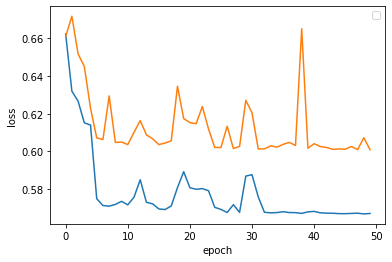

In [28]:
# In history

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [29]:
# Kiểm tra việc tái tạo trong tập test
import numpy as np

# Dự đoán
predicts = auto_encoder_model.predict(X_test)
mse = np.mean(np.power(X_test - predicts,2), axis=1)
err_df = pd.DataFrame({'error': mse, 'truth': y_test})


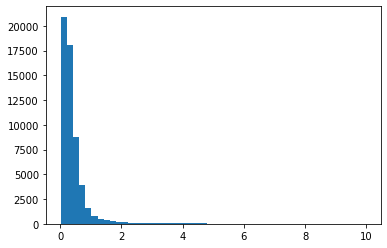

In [33]:
# In ra histogram của error khi tái tạo các điểm Normal trong tập test
normal_error_df = err_df[(err_df['truth']==0) & (err_df['error'] < 10)]

_ = plt.hist(normal_error_df.error.values, bins= 50)

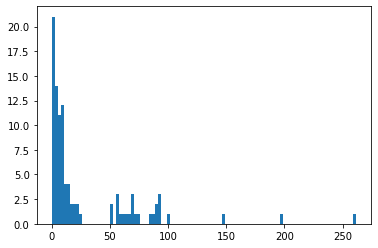

In [36]:
# In ra histogram của error khi tái tạo các điểm Fraud trong tập test
fraud_error_df = err_df[(err_df['truth']==1)]
_ = plt.hist(fraud_error_df.error.values, bins= 100)

<function matplotlib.pyplot.show>

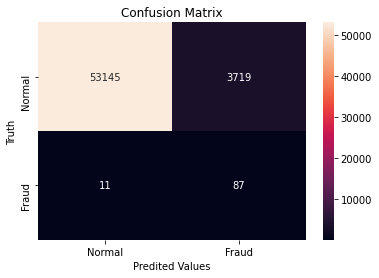

In [42]:
# Vẽ ra confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 1

y_pred = [1 if e > threshold else 0 for e in err_df.error.values]
conf_matrix = confusion_matrix(err_df.truth, y_pred)

# Vẽ
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=['Normal','Fraud'], annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predited Values")
plt.ylabel("Truth")
plt.show